# Calculate song information contained in individual MA neurons

Because each neuron maps song to a single real number, $r_i = f_i[s(t < t')]$, the mutual info $MI[r_i, s]$ is given simply by the response entropy $H[r_i]$, since

$$MI[r_i, s] = H[r_i] - E_s[H[r_i|s]] = H[r_i]$$

since $H[r_i|s] = H[f_i(s)|s] = 0$, i.e. there is no noise, so each song maps to exactly one neural response value.

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from disp import set_plot
from record import smlt_ppln_ma


cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

PFX_NRL = f'data/simple/mlv/ma_built/nrl_ctl/ma_built_nrl_rand_bnry'

Load behavioral data from Coen et al 2014

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

## Define complete neural population

In [4]:
# neural params
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

nr = len(tau_rs)
r_cols = [f'R_{cr}' for cr in range(nr)]

## Simulate population recordings

In [5]:
# record data
for itr, df_tr in zip(ISTRAIN, dfs_tr):
    sys.stdout.write('.')
    
    df_tr_nrl = df_tr.copy()

    i_s = (np.random.rand(len(df_tr_nrl)) < .5).astype(float)
    i_p = (np.random.rand(len(df_tr_nrl)) < .5).astype(float)
    
    # simulate population response
    rs = smlt_ppln_ma(i_s, i_p, tau_rs, tau_as, x_ss, x_ps, DT)

    df_tr_nrl[r_cols] = rs

    np.save(f'{PFX_NRL}_tr_{itr}.npy', np.array([{'df': df_tr_nrl}]))

.......................................................................................

# Compute information

In [6]:
# load all neural recordings
dfs_tr = [np.load(f'{PFX_NRL}_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

In [7]:
R_COLS = [f'R_{ir}' for ir in range(nr)]

# keep all neural activity
# frs = cc([np.array(df_tr[R_COLS]) for df_tr in dfs_tr])

# only keep neural activity after first song onset
it_song_starts = [np.nonzero(np.array(df_tr['Q']) == 0)[0][0] for df_tr in dfs_tr]
frs = cc([np.array(df_tr[R_COLS])[it_song_start:, :] for df_tr, it_song_start in zip(dfs_tr, it_song_starts)])

dfs_tr = None

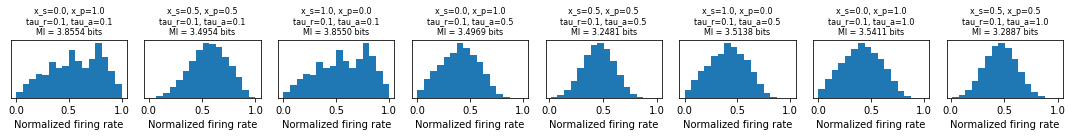

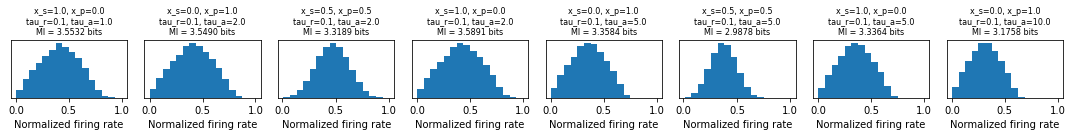

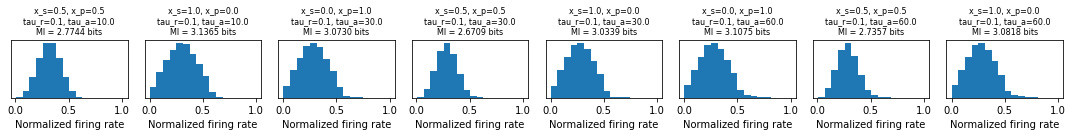

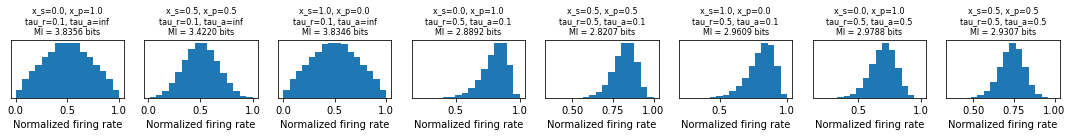

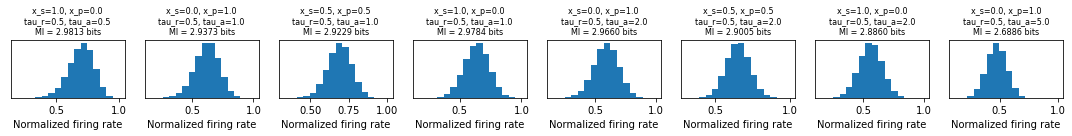

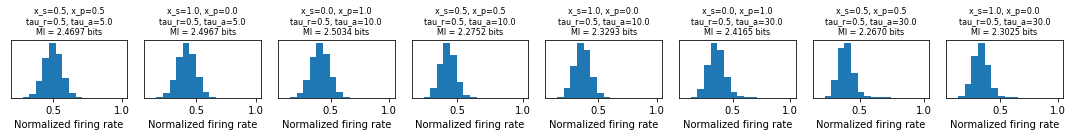

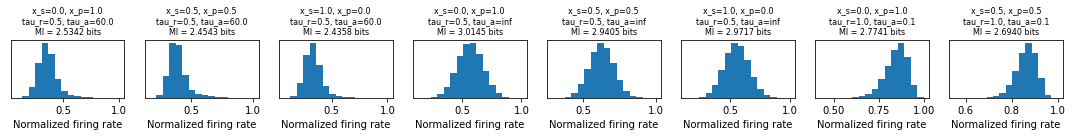

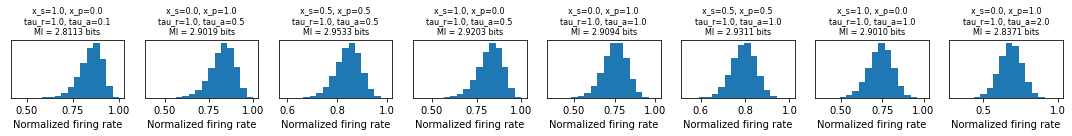

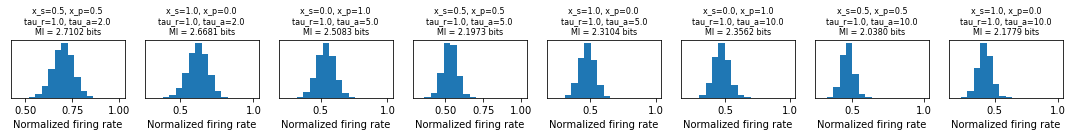

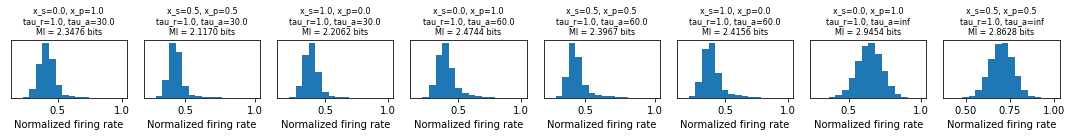

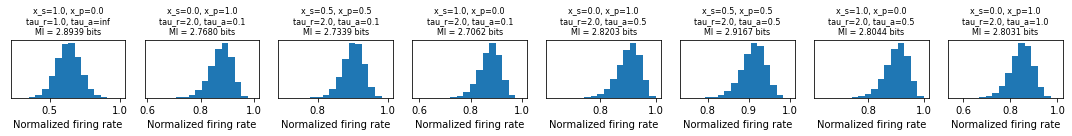

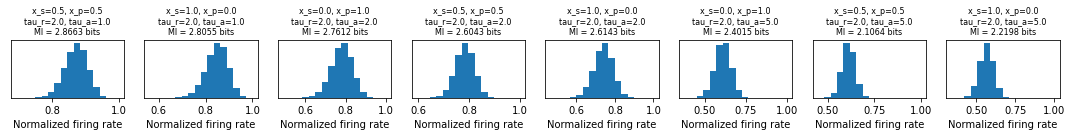

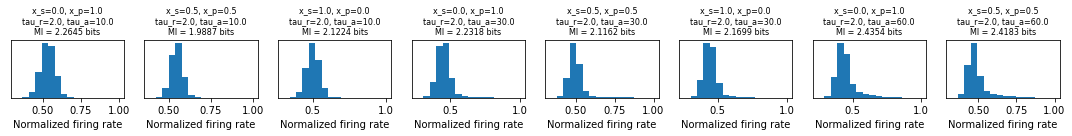

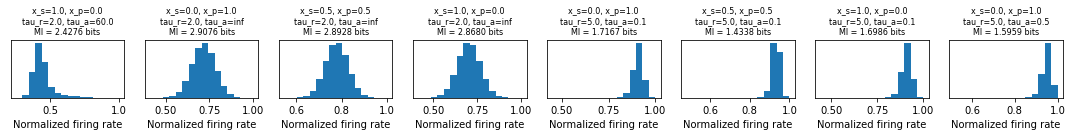

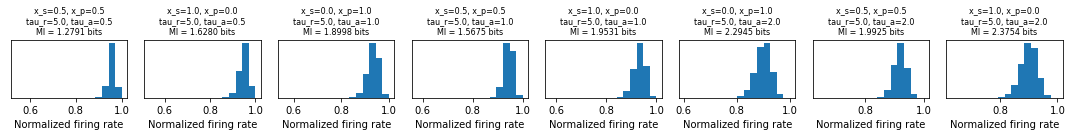

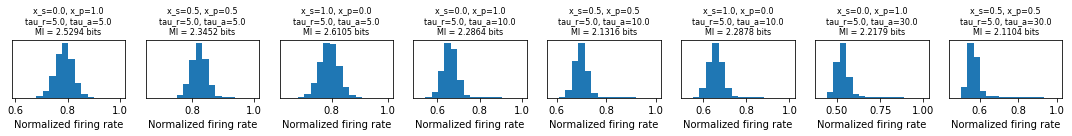

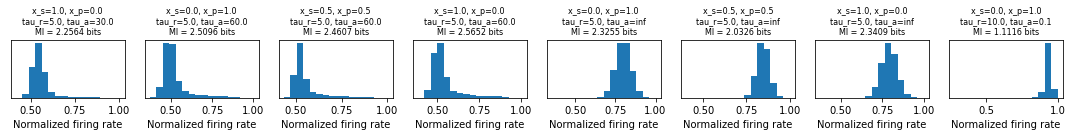

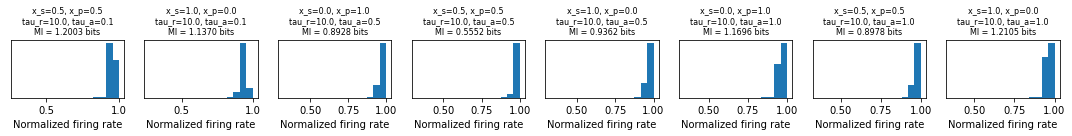

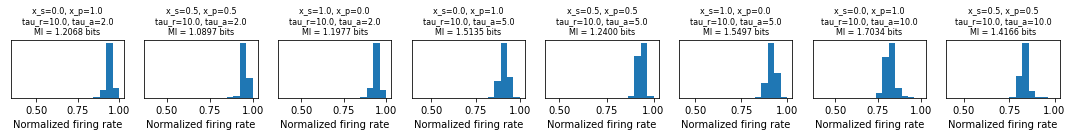

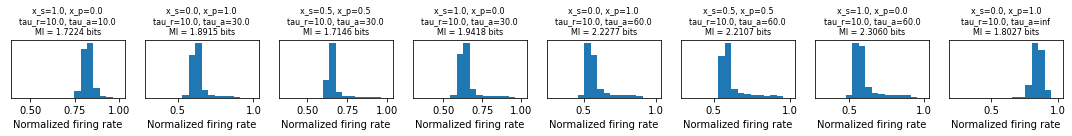

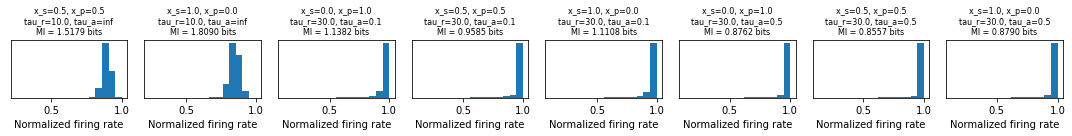

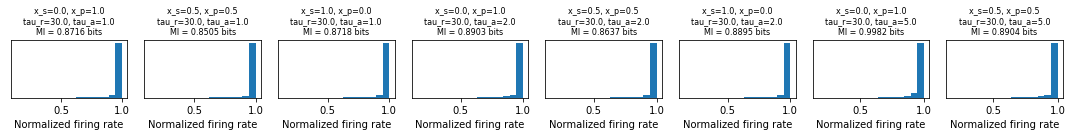

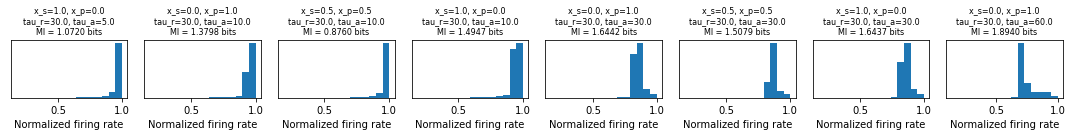

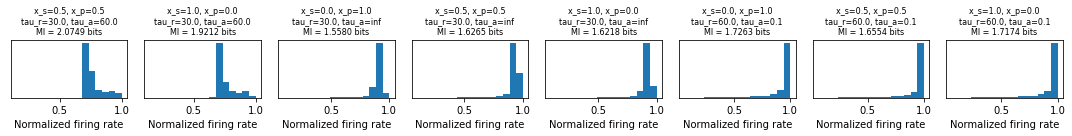

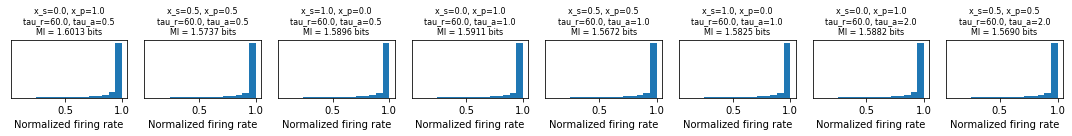

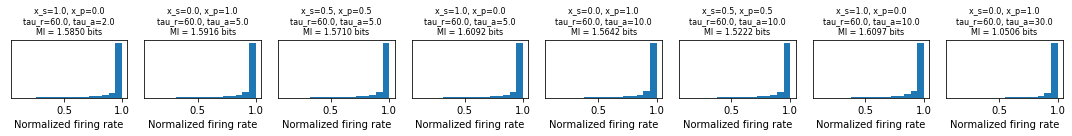

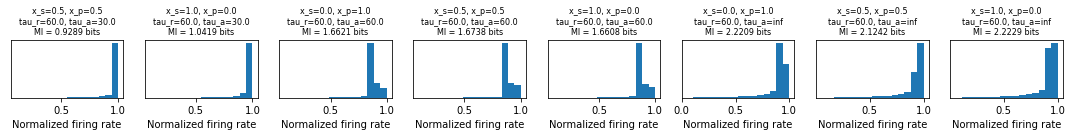

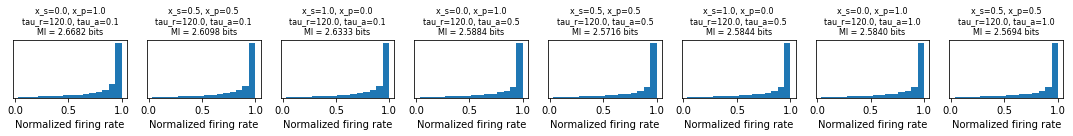

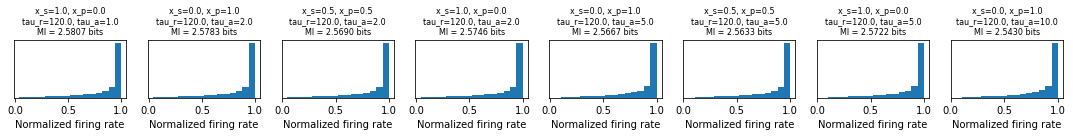

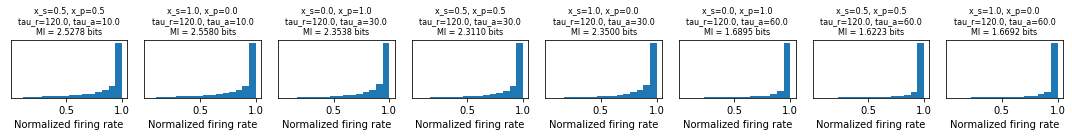

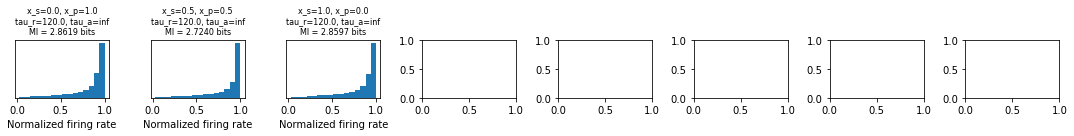

In [8]:
ncol = 8
cnrn = 0
nbin = 16
ents = np.nan * np.zeros(nr)
for istart in range(0, frs.shape[1], ncol):
    fig, axs = plt.subplots(1, ncol, figsize=(15, 2), tight_layout=True)
    for ax, fr in zip(axs, frs[:, istart:istart+ncol].T):
        fr /= fr.max()
        cts_fr, bins = np.histogram(fr, bins=nbin)
        binc = .5*(bins[:-1] + bins[1:])
        p_fr = cts_fr/cts_fr.sum()
        
        ent = stats.entropy(p_fr, base=2)
        ents[cnrn] = ent
        
        ax.bar(binc, p_fr, width=(bins[1] - bins[0]))
        
        ax.set_xlabel('Normalized firing rate')
        ax.set_title(f'x_s={x_ss[cnrn]}, x_p={x_ps[cnrn]}\ntau_r={tau_rs[cnrn]:.1f}, tau_a={tau_as[cnrn]:.1f}\nMI = {ent:.4f} bits', fontsize=8)
        ax.yaxis.set_visible(False)
        cnrn += 1

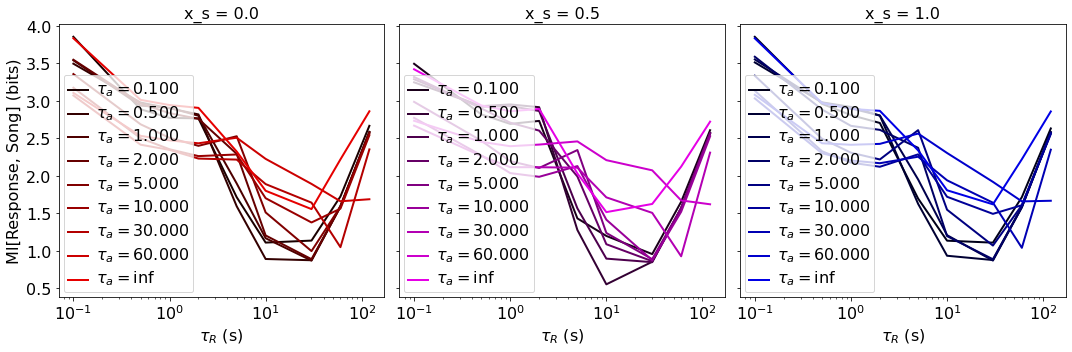

In [9]:
# plot entropies vs tau_r, tau_a, and selectivity
fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True, sharex=True, sharey=True)
colors = [np.array([1, 0, 0]), np.array([1, 0, 1]), np.array([0, 0, 1])]

for ax, c, x_s in zip(axs, colors, X_S):
    mx_s = np.isclose(x_ss, x_s)
    # loop over adaptation rates
    for ctau_a, tau_a in enumerate(TAU_A):
        if ~np.isinf(tau_a):
            mtau_a = np.isclose(tau_as, tau_a)
        else:
            mtau_a = np.isinf(tau_as)
        
        # get tau_rs and entropies of neurons with this x_s and tau_a
        tau_rs_ = tau_rs[mx_s & mtau_a]
        ents_ = ents[mx_s & mtau_a]
        
        color = c*(.1 + (1-.1)*ctau_a/len(TAU_A))
        ax.semilogx(tau_rs_, ents_, lw=2, c=color)
    
    ax.set_xlabel(r'$\tau_R$ (s)')
    ax.set_title(f'x_s = {x_s}')
    ax.legend([r'$\tau_a = $' + f'{tau_a:.3f}' for tau_a in TAU_A])
    
axs[0].set_ylabel('MI[Response, Song] (bits)')
for ax in axs:
    set_plot(ax, font_size=16)

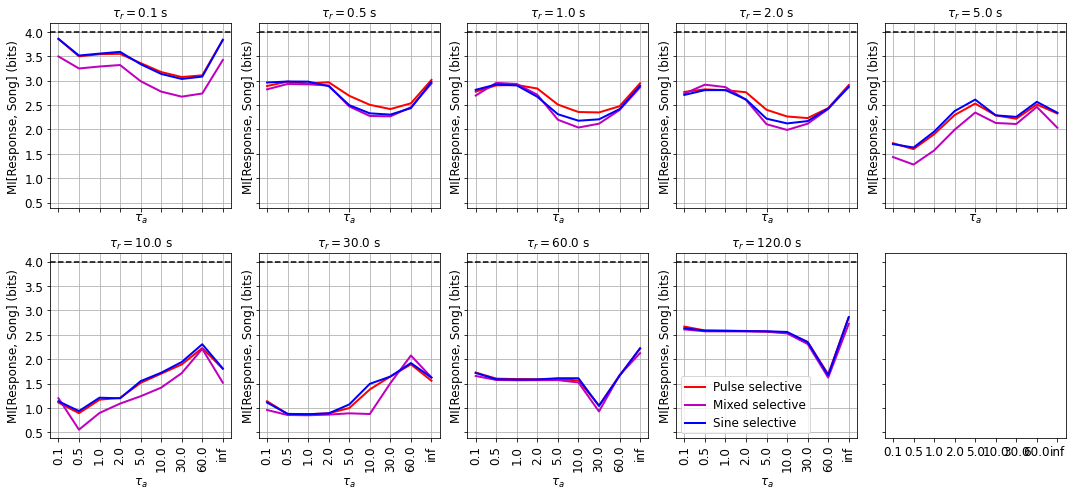

In [11]:
# plot entropy vs TAU_A for several different TAU_R
ntau_r = 9
colors = ['r', 'm', 'b']

fig, axs = plt.subplots(2, 5, figsize=(15, 7), tight_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

for cax, (ax, tau_r) in enumerate(zip(axs, TAU_R[-ntau_r:])):
    mtau_r = np.isclose(tau_rs, tau_r)
    for x_s, c in zip(X_S, colors):
        mx_s = np.isclose(x_ss, x_s)
        # get tau_as and entropies of responses w/ this tau_r and x_s
        tau_as_ = tau_as[mtau_r & mx_s]
        ents_ = ents[mtau_r & mx_s]
        
        assert list(tau_as_) == sorted(tau_as_)
        
        ax.plot(np.arange(len(TAU_A)), ents_, lw=2, c=c)
        
    ax.axhline(np.log2(nbin), c='k', ls='--')
        
    ax.set_xticks(np.arange(len(TAU_A)))
    ax.set_xticklabels([f'{tau_a}' for tau_a in TAU_A], rotation=90)
    ax.set_xlabel(r'$\tau_a$')
    ax.set_ylabel('MI[Response, Song] (bits)')
    ax.set_title(r'$\tau_r =$' + f'{tau_r} s')
    ax.grid()
    
ax.legend(['Pulse selective', 'Mixed selective', 'Sine selective'])

for ax in axs:
    set_plot(ax, font_size=12)